<a target="_blank" href="https://colab.research.google.com/github/sonder-art/neuroscience/blob/main/50_s_pls.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Execute the next cells to install the necessary libraries in `Colab`

In [5]:
import os

# Set the environment variable
os.environ['SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL'] = 'True'
# Verify if it's set correctly
print(os.environ.get('SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL'))


In [6]:
!pip install py-ddspls
#!pip install requests

In [7]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [8]:
import py_ddspls

The next cell can only be executed if you are running the notebook locally, if you are in `Colab` skip it.

In [9]:
#from utils.brain import matrix_from_vector

In [10]:
import numpy as np
def upper_vectorization(A:np.array):
    triangle = np.triu(A, 1)
    vector = triangle[np.triu_indices(triangle.shape[0], 1)]

    return vector


def matrix_from_vector(v, n):
    matrix = np.zeros((n, n))
    i_upp = np.triu_indices(n, 1)
    matrix[i_upp] = v
    i_low = np.tril_indices(n, -1)
    matrix[i_low] = matrix.T[i_low]
    
    return matrix

## Subject demographics

In [11]:
demo_std_path = 'data/output/processed_demographics.csv'

Execute the cell below if you are on `Colab` if you are running this folder locally then there is no need for downloading the data.

In [12]:
demo_std_path = 'https://github.com/sonder-art/neuroscience/raw/main/data/output/processed_demographics.csv'


In [13]:
demo_std = pd.read_csv(demo_std_path)
print('demographics',demo_std.shape)

demographics (50, 11)


In [14]:
demo_names = demo_std.columns[1:]

## Subject brain vectors

Execute the cell below if you are on `Colab` if you are running this folder locally then there is no need for downloading the data.

In [15]:
import os
import requests
# Github Path
file_urls = ['https://github.com/sonder-art/neuroscience/raw/main/data/output/subject_brain_vectors.npy']
series_path = 'data/output/'

# Ensure the save folder exists
os.makedirs(series_path, exist_ok=True)

for url in file_urls:
    # Extract the file name
    file_name = url.split('/')[-1]
    
    # Full path for saving the file
    save_path = os.path.join(series_path, file_name)

    # Download and save the file
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")


Downloaded subject_brain_vectors.npy


In [16]:
stackedVecs = np.load('data/output/subject_brain_vectors.npy')
stackedVecs.shape

(50, 54946)

## Partial Leas Squares (Sparse)

In [17]:
X, Y = stackedVecs, demo_std.iloc[:,1:]
print(f'X: {X.shape}')
#print(X.columns.values)
print(f'y: {Y.shape}')

X: (50, 54946)
y: (50, 10)


In [18]:
n_components = 4

In [19]:
lambd = 0.0
Xs = {0:X}

model_0 = py_ddspls.model.ddspls(Xs, Y, lambd=lambd, R=n_components, mode="reg", verbose=True)

y_loads_zero = model_0.model.v
x_loads_zero = model_0.model.u[0]

In [20]:
lambdas = np.linspace(0.0, 0.35, 36)
lambdas

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35])

In [21]:
brain_size = 332

In [22]:
Xs = {0:X}

y_loadings = []
x_loadings_vec = []
x_loadings_mat = []
for l in lambdas:
    sparse_model = py_ddspls.model.ddspls(Xs, Y, lambd=l, R=n_components, mode="reg", verbose=True)
    y_loadings.append(sparse_model.model.v)
    
    x_loadings_vec.append(sparse_model.model.u[0])
    xinner = []
    for c in range(n_components):
        xinner.append(matrix_from_vector(sparse_model.model.u[0][:,c], brain_size))
    x_loadings_mat.append(xinner)
y_loadings = np.array(y_loadings)
x_loadings_mat = np.array(x_loadings_mat)
x_loadings_vec = np.array(x_loadings_vec)
print('Y Vector:', y_loadings.shape)
print('X Vector:', x_loadings_vec.shape)
print('X Matrix:', x_loadings_mat.shape)

Y Vector: (36, 10, 4)
X Vector: (36, 54946, 4)
X Matrix: (36, 4, 332, 332)


In [23]:
referenceY_sparse = y_loads_zero
referenceX_sparse = x_loads_zero

y_loadings_outer = []
x_loadings_vec_outer = []
x_loadings_mat_outer = []

y_latent_outer = []
x_latent_outer = []

corr_outer = []
for component in range(n_components):
    y_loadings_inner = []
    x_loadings_vec_inner = []
    x_loadings_mat_inner = []
    
    y_latent_inner = []
    x_latent_inner = []
    
    corr_inner = []
    for idx, l in enumerate(lambdas):
        if idx==0:
            #lambda_zero = (y_loadings[idx,:,component])
            
            lambda_zero = sparse_model.model.v[:,component]
            # EL CAMBIO EN LAMDA ZERO (BAR PLOT) ES PORQUE NO USA MODEL_ZERO EN LA LISTA Y QUIZA LA CORR NO ES SUFICIENTE
            

        rY_sparse = np.corrcoef(referenceY_sparse[:,component], y_loadings[idx,:,component])[0,1]
        rX_sparse = np.corrcoef(referenceX_sparse[:,component], x_loadings_vec[idx,:,component])[0,1]

        
        if (rY_sparse < -0.1):
            lambda_iy = -1*y_loadings[idx,:,component] ### -1
            y_loadings_inner.append(lambda_iy)
        else :
            lambda_iy = y_loadings[idx,:,component]
            y_loadings_inner.append(lambda_iy)

            
        if (rX_sparse < -0.1):
            lambda_ix = -1*x_loadings_vec[idx,:,component] ### -1
            x_loadings_vec_inner.append(lambda_ix)
            x_loadings_mat_inner.append(matrix_from_vector(lambda_ix, brain_size))
        else :
            lambda_ix = x_loadings_vec[idx,:,component]
            x_loadings_vec_inner.append(lambda_ix)
            x_loadings_mat_inner.append(matrix_from_vector(lambda_ix, brain_size))


        y_vec = (Y@lambda_iy)
        x_vec = (X@lambda_ix)
    
        rcov = np.round(np.cov(x_vec, y_vec)[1,0],2)
        rcor = np.round(np.corrcoef(x_vec, y_vec)[1,0],2)
        
        corr_inner.append((rcov,rcor))
        
        y_latent_inner.append(y_vec)
        x_latent_inner.append(x_vec)
            
    y_loadings_outer.append(y_loadings_inner)
    x_loadings_vec_outer.append(x_loadings_vec_inner)
    x_loadings_mat_outer.append(x_loadings_mat_inner)
    
    y_latent_outer.append(y_latent_inner)
    x_latent_outer.append(x_latent_inner)
    
    corr_outer.append(corr_inner)

y_loadings_outer = np.array(y_loadings_outer)
x_loadings_vec_outer = np.array(x_loadings_vec_outer)
x_loadings_mat_outer = np.array(x_loadings_mat_outer)
y_latent_outer = np.array(y_latent_outer)
x_latent_outer = np.array(x_latent_outer)
corr_outer = np.array(corr_outer)

print('\nY Vector:', y_loadings_outer.shape)
print('X Matrix:', x_loadings_vec_outer.shape)
print('X Vector:', x_loadings_mat_outer.shape,'\n')
print('Y Latent:', y_latent_outer.shape)
print('X Latent:', x_latent_outer.shape)


Y Vector: (4, 36, 10)
X Matrix: (4, 36, 54946)
X Vector: (4, 36, 332, 332) 

Y Latent: (4, 36, 50)
X Latent: (4, 36, 50)


## Optimal lambdas

In [24]:
lc1,lc2,lc3,lc4 = 11, 11, 11, 11

In [25]:
important = demo_names

In [26]:
Y.columns = demo_names
Y.columns

Index(['sex', 'age', 'education', 'fhd', 'aud_1', 'pca_alcohol_1',
       'pca_alcohol_2', 'pca_urgency', 'pca_behavior_1', 'pca_behavior_2'],
      dtype='object')

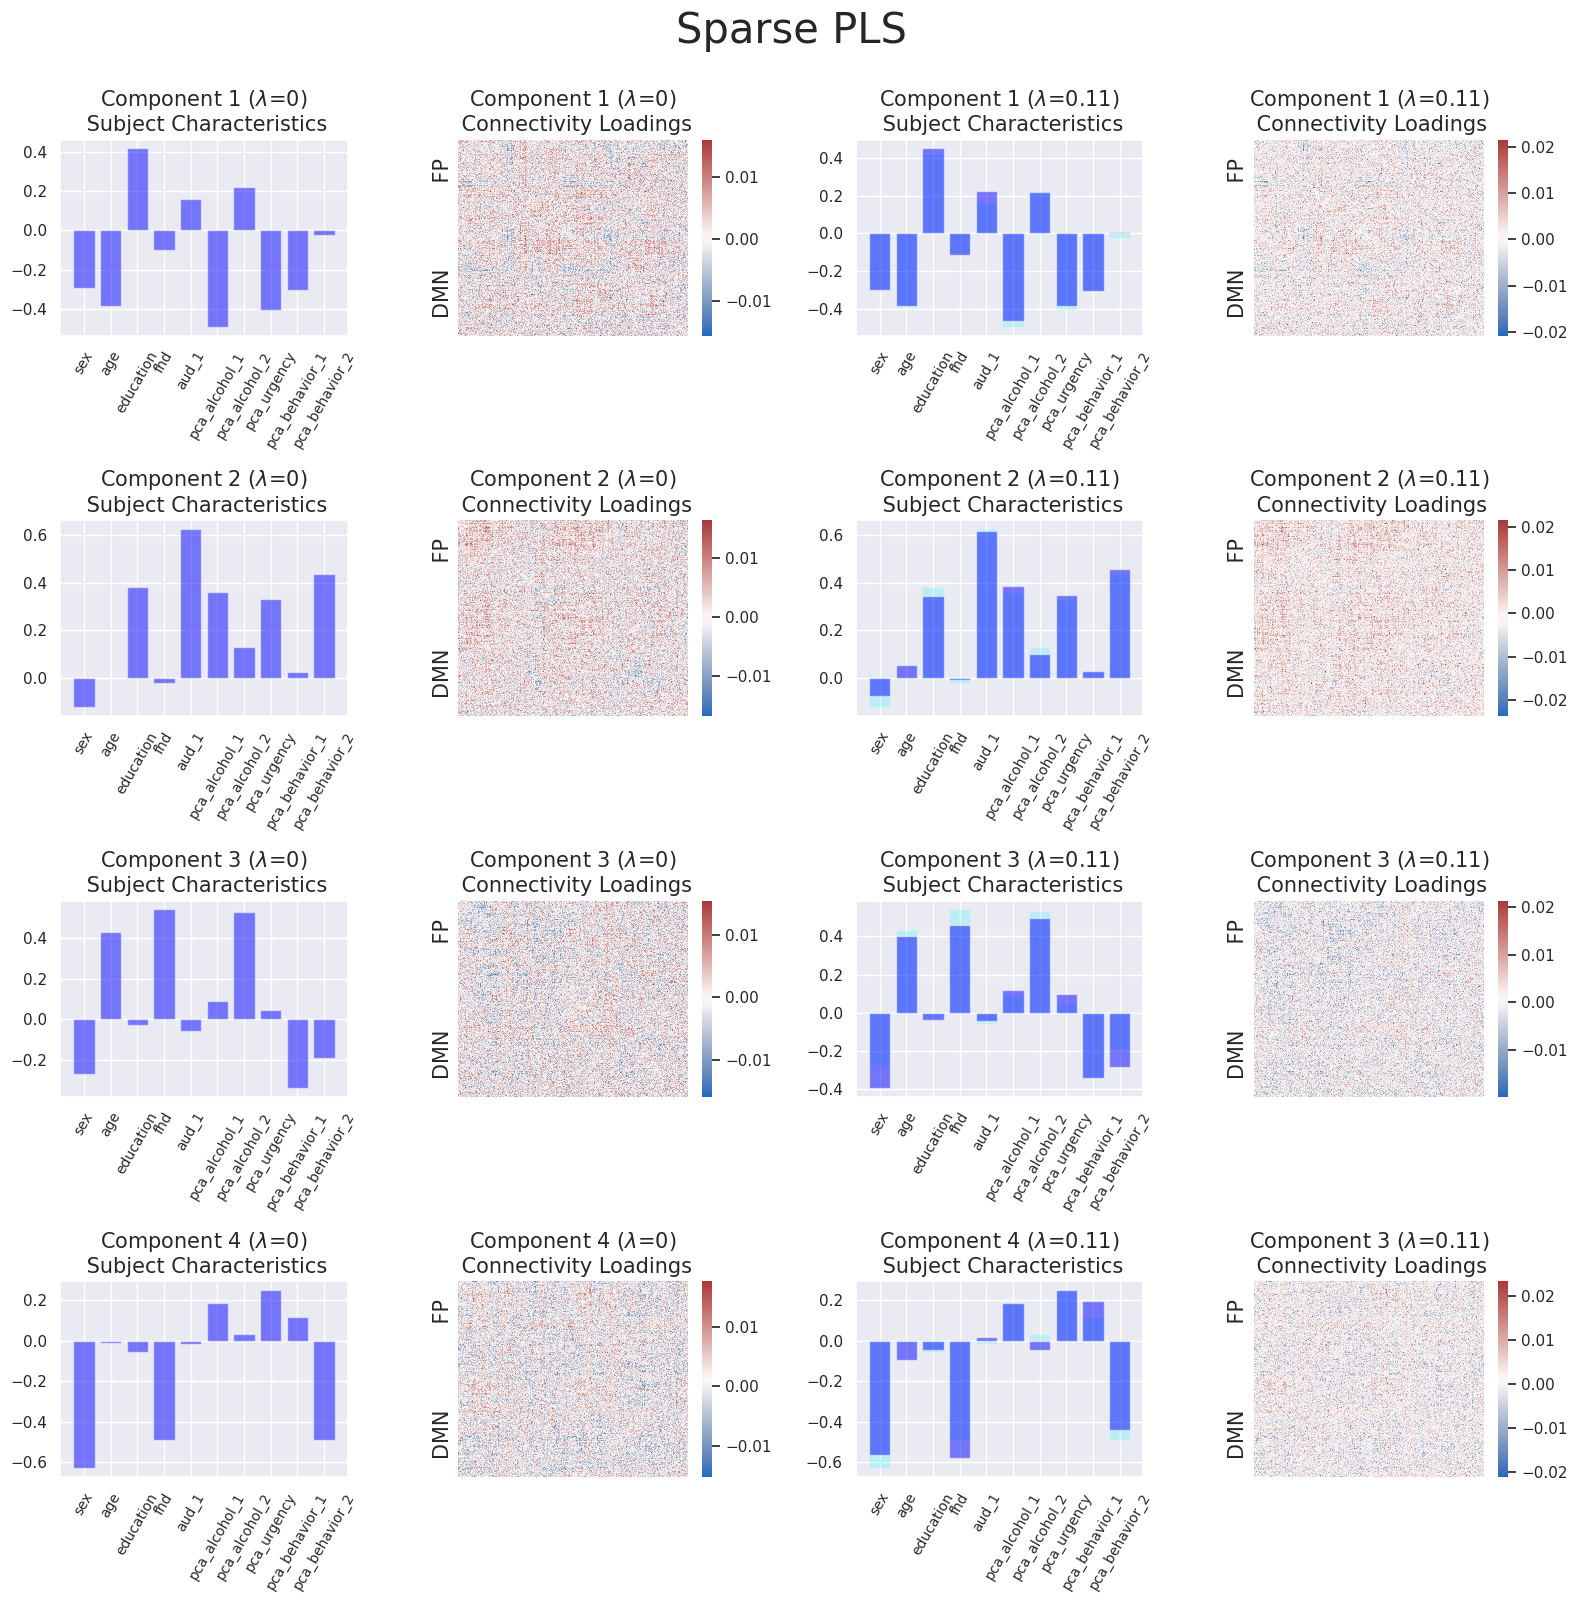

In [27]:
fig = plt.figure(figsize=(16, 16))
fig.suptitle('Sparse PLS', fontsize=30, y=1)

colors =['blue' if p in important else 'gray' for p in Y.columns]
names = [p if p in important else '' for p in Y.columns]

### Y COMPONENTS
plt.subplot(441)
plt.title('Component 1 ($\lambda$=0)\n Subject Characteristics', fontsize=15)
plt.bar(Y.columns, y_loadings_outer[0,0,:], color=colors, alpha=0.5)
plt.xticks(rotation=60, fontsize=10)
plt.subplot(443)
plt.title(f'Component 1 ($\lambda$={lambdas[lc1]:.2f})\n Subject Characteristics', fontsize=15)
plt.bar(Y.columns, y_loadings_outer[0,0,:], color='cyan', alpha=0.2)
plt.bar(Y.columns, y_loadings_outer[0,lc1,:], color=colors, alpha=0.5)
plt.xticks(rotation=60, fontsize=10)


plt.subplot(445)
plt.title('Component 2 ($\lambda$=0)\n Subject Characteristics', fontsize=15)
plt.bar(Y.columns, y_loadings_outer[1,0,:], color=colors, alpha=0.5)
plt.xticks(rotation=60, fontsize=10)
plt.subplot(447)
plt.title(f'Component 2 ($\lambda$={lambdas[lc2]:.2f})\n Subject Characteristics', fontsize=15)
plt.bar(Y.columns, y_loadings_outer[1,0,:], color='cyan', alpha=0.2)
plt.bar(Y.columns, y_loadings_outer[1,lc2,:], color=colors, alpha=0.5)
plt.xticks(rotation=60, fontsize=10)


plt.subplot(449)
plt.title('Component 3 ($\lambda$=0)\n Subject Characteristics', fontsize=15)
plt.bar(Y.columns, y_loadings_outer[2,0,:], color=colors, alpha=0.5)
plt.xticks(rotation=60, fontsize=10)
plt.subplot(4,4,11)
plt.title(f'Component 3 ($\lambda$={lambdas[lc3]:.2f})\n Subject Characteristics', fontsize=15)
plt.bar(Y.columns, y_loadings_outer[2,0,:], color='cyan', alpha=0.2)
plt.bar(Y.columns, y_loadings_outer[2,lc3,:], color=colors, alpha=0.5)
plt.xticks(rotation=60, fontsize=10)


plt.subplot(4,4,13)
plt.title('Component 4 ($\lambda$=0)\n Subject Characteristics', fontsize=15)
plt.bar(Y.columns, y_loadings_outer[3,0,:], color=colors, alpha=0.5)
plt.xticks(rotation=60, fontsize=10)
plt.subplot(4,4,15)
plt.title(f'Component 4 ($\lambda$={lambdas[lc4]:.2f})\n Subject Characteristics', fontsize=15)
plt.bar(Y.columns, y_loadings_outer[3,0,:], color='cyan', alpha=0.2)
plt.bar(Y.columns, y_loadings_outer[3,lc4,:], color=colors, alpha=0.5)
plt.xticks(rotation=60, fontsize=10)


### X COMPONENTS
plt.subplot(442)
plt.title('Component 1 ($\lambda$=0)\n Connectivity Loadings', fontsize=15)
ax = sns.heatmap(x_loadings_mat_outer[0,0,:,:], cmap='vlag')
ax.set_ylabel('DMN             FP', fontsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[-1].yaxis.label.set_weight('bold')
plt.xticks([])
plt.yticks([])
plt.subplot(444)
plt.title(f'Component 1 ($\lambda$={lambdas[lc1]:.2f})\n Connectivity Loadings', fontsize=15)
ax = sns.heatmap(x_loadings_mat_outer[0,lc1,:,:], cmap='vlag')
ax.set_ylabel('DMN             FP', fontsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[-1].yaxis.label.set_weight('bold')
plt.xticks([])
plt.yticks([])



plt.subplot(446)
plt.title('Component 2 ($\lambda$=0)\n Connectivity Loadings', fontsize=15)
ax = sns.heatmap(x_loadings_mat_outer[1,0,:,:], cmap='vlag')
ax.set_ylabel('DMN             FP', fontsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[-1].yaxis.label.set_weight('bold')
plt.xticks([])
plt.yticks([])
plt.subplot(448)
plt.title(f'Component 2 ($\lambda$={lambdas[lc2]:.2f})\n Connectivity Loadings', fontsize=15)
ax = sns.heatmap(x_loadings_mat_outer[1,lc2,:,:], cmap='vlag')
ax.set_ylabel('DMN             FP', fontsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[-1].yaxis.label.set_weight('bold')
plt.xticks([])
plt.yticks([])



plt.subplot(4,4,10)
plt.title('Component 3 ($\lambda$=0)\n Connectivity Loadings', fontsize=15)
ax = sns.heatmap(x_loadings_mat_outer[2,0,:,:], cmap='vlag')
ax.set_ylabel('DMN             FP', fontsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[-1].yaxis.label.set_weight('bold')
plt.xticks([])
plt.yticks([])
plt.subplot(4,4,12)
plt.title(f'Component 3 ($\lambda$={lambdas[lc3]:.2f})\n Connectivity Loadings', fontsize=15)
ax = sns.heatmap(x_loadings_mat_outer[2,lc3,:,:], cmap='vlag')
ax.set_ylabel('DMN             FP', fontsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[-1].yaxis.label.set_weight('bold')
plt.xticks([])
plt.yticks([])


plt.subplot(4,4,14)
plt.title('Component 4 ($\lambda$=0)\n Connectivity Loadings', fontsize=15)
ax = sns.heatmap(x_loadings_mat_outer[3,0,:,:], cmap='vlag')
ax.set_ylabel('DMN             FP', fontsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[-1].yaxis.label.set_weight('bold')
plt.xticks([])
plt.yticks([])
plt.subplot(4,4,16)
plt.title(f'Component 3 ($\lambda$={lambdas[lc4]:.2f})\n Connectivity Loadings', fontsize=15)
ax = sns.heatmap(x_loadings_mat_outer[3,lc4,:,:], cmap='vlag')
ax.set_ylabel('DMN             FP', fontsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.figure.axes[-1].yaxis.label.set_weight('bold')
plt.xticks([])
plt.yticks([])



plt.tight_layout()
plt.show()

In [28]:
selected = []
for component, l in enumerate([lc1,lc2,lc3,lc4]):
    print(f'Component:{component}, Lambda: {l}')
    temp = x_loadings_mat_outer[component, l, :, :]
    selected.append(temp)
selected = np.array(selected)
selected.shape

Component:0, Lambda: 11
Component:1, Lambda: 11
Component:2, Lambda: 11
Component:3, Lambda: 11


(4, 332, 332)

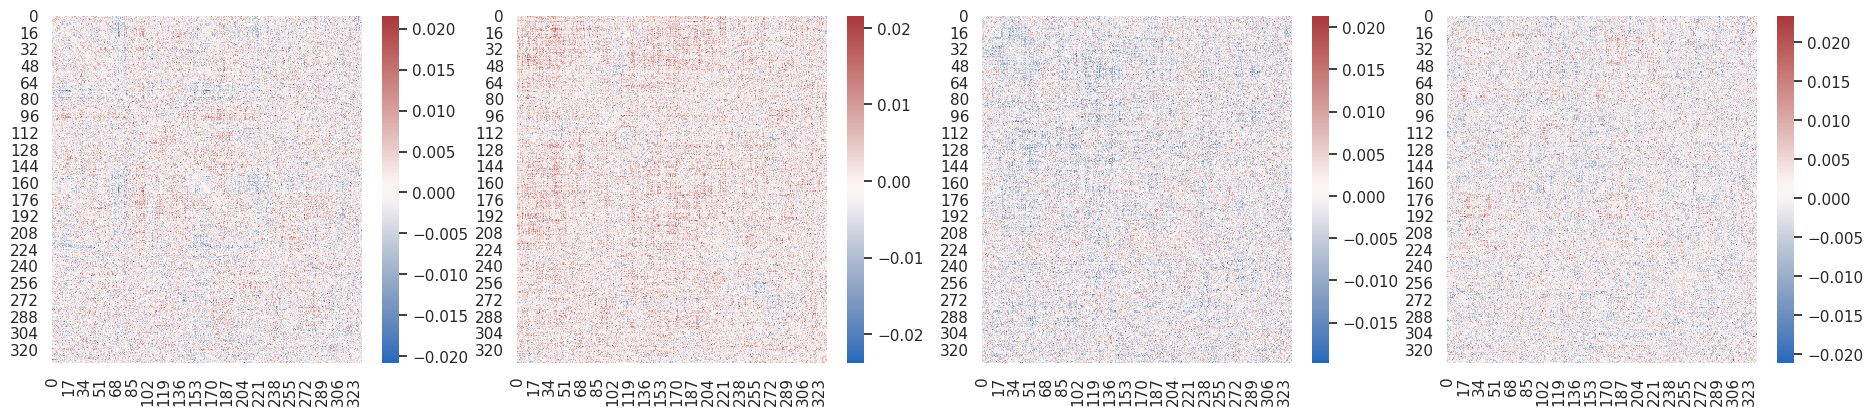

In [29]:
fig = plt.figure(figsize=(23,4.5))

for component in range(n_components):
    axes = fig.add_subplot(1, 4, component+1)
    sns.heatmap(selected[component, :, :], cmap='vlag')

In [31]:
os.makedirs('data/output', exist_ok=True)
np.save('data/output/selected_loadings', selected)